# Modelo APC bayesiano

In [6]:
# Imports y configuración
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
# Nombre del notebook (fallback si no puede detectarse automáticamente)
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "a_03_lee_carter_renshaw_haberman.ipynb")))[0]
# Carpeta base de outputs y subcarpeta específica del notebook
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

# Ajustes de display
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (10, 5)


Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman


In [7]:
# Estilo unificado para gráficos
import sys, os

# Añadir carpeta "src" al PYTHONPATH (robusto a distintas ubicaciones)
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)

# Recargar el módulo si ya estaba importado (útil al iterar)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap

# Fondo blanco y estilo claro
apply_matplotlib_style(
    n_colors=7, base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)

# Etiquetas para el grupo etario
etiquetas_gr = {
    1:"0–4", 2:"5–9", 3:"10–14", 4:"15–19", 5:"20–24", 6:"25–29",
    7:"30–34", 8:"35–39", 9:"40–44", 10:"45–49", 11:"50–54", 12:"55–59",
    13:"60–64", 14:"65–69", 15:"70–74", 16:"75–79", 17:"≥80", 
}


In [8]:
# Carga de datos: opción 1 (tabla larga)
# Archivo esperado con columnas: ano, gr_et (grupo etario), tasa_x100k, tasa (por persona)
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
print(df_long.head())

# Seleccionamos tasa por 100k y convertimos a por persona (m)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m["m"] = df_long_m["tasa_x100k"] / 1e5
# Protegemos contra ceros para el log
EPS = 1e-12
df_long_m["m"] = df_long_m["m"].clip(lower=EPS)

# Pivot a matriz edad×año
mat = df_long_m.pivot(index="age", columns="year", values="m").sort_index()
mat.head()


    ano  t  gr_et  poblacion  conteo_defunciones  tasa_x100k      tasa
0  1979  1      1    3569687               175.0    4.902391  0.000049
1  1979  1      2    3394629                41.0    1.207790  0.000012
2  1979  1      3    3405357                31.0    0.910330  0.000009
3  1979  1      4    3157420                48.0    1.520229  0.000015
4  1979  1      5    2680815                90.0    3.357188  0.000034


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


## Modelado

### Notas y posibles mejoras

- Suavizado: cambiar priors a RandomWalk orden 2 (RW2) para edad, período y cohorte.
- Cohortes: usar puntos medios de grupos etarios para un año de nacimiento más realista.
- Overdispersión: si se dispone de conteos y exposiciones, modelar con Poisson/Gamma (modelo multiplicativo) o NegBin.
- Identificabilidad: añadir restricciones lineales (p.ej. sumas y sumas ponderadas) para separar deriva temporal.
- Validación más robusta: incorporar métricas adicionales (sMAPE, cobertura de intervalos, log-score).


In [ ]:
# Gráficos de efectos y desempeño
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos medias posteriores de efectos centrados
alpha_mean = alpha_post_c.mean(axis=(0,1))
beta_mean = beta_post_c.mean(axis=(0,1))
gamma_mean = gamma_post_c.mean(axis=(0,1))

fig, axs = plt.subplots(3,1, figsize=(10,12), sharex=False)
axs[0].plot(ages, alpha_mean, marker='o'); axs[0].set_title('Efecto Edad (α centrado)'); axs[0].set_xlabel('Grupo edad'); axs[0].set_ylabel('α')
axs[1].plot(all_periods, beta_mean[:len(all_periods)], marker='o'); axs[1].set_title('Efecto Período (β centrado)'); axs[1].set_xlabel('Período'); axs[1].set_ylabel('β')
axs[2].plot(all_cohorts, gamma_mean, marker='o'); axs[2].set_title('Efecto Cohorte (γ centrado)'); axs[2].set_xlabel('Cohorte (aprox)'); axs[2].set_ylabel('γ')
plt.tight_layout()
plt.show()

# Comparación agregada por período en validación (promedio sobre edades)
df_period_val = df_val_eval.groupby('period')[['obs','pred']].mean().reset_index()
plt.figure(figsize=(8,4))
plt.plot(df_period_val['period'], df_period_val['obs'], label='Obs', marker='o')
plt.plot(df_period_val['period'], df_period_val['pred'], label='Pred', marker='o')
plt.title('Promedio sobre edades: Observado vs Predicho (Validación)')
plt.xlabel('Período'); plt.ylabel('Tasa m'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# Heatmap pred vs obs (validación)
mat_val_pred = m_val_pred_mean.reshape(n_age, len(val_periods))
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.heatmap(val_mat.values, ax=ax[0], cmap='viridis'); ax[0].set_title('Observado (validación)'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Edad')
ax[0].set_xticklabels(val_periods, rotation=45)
sns.heatmap(mat_val_pred, ax=ax[1], cmap='viridis'); ax[1].set_title('Predicho (validación)'); ax[1].set_xlabel('Período'); ax[1].set_ylabel('Edad')
ax[1].set_xticklabels(val_periods, rotation=45)
plt.tight_layout(); plt.show()

print("Visualizaciones generadas.")

### Visualización de efectos y desempeño

Graficamos efectos centrados y comparación observada vs predicha en validación (agregado por período y edad).

In [ ]:
# Predicciones para validación
import numpy as np

# Construir índices para validación (similar a train)
age_idx_val = np.repeat(np.arange(n_age), len(val_periods))
period_idx_val = np.tile(np.arange(len(train_periods), len(train_periods)+len(val_periods)), n_age)  # offset dentro de beta
# cohort_idx_val ya calculado arriba

# Extraer arrays del traza
alpha_post = trace.posterior["alpha"].values  # (chains, draws, n_age)
beta_post = trace.posterior["beta"].values    # (chains, draws, n_periods_total)
gamma_post = trace.posterior["gamma"].values  # (chains, draws, n_cohort_total)

# Centrados (reaplicar para consistencia)
alpha_post_c = alpha_post - alpha_post.mean(axis=2, keepdims=True)
beta_post_c = beta_post - beta_post.mean(axis=2, keepdims=True)
gamma_post_c = gamma_post - gamma_post.mean(axis=2, keepdims=True)

# Efectos para cada celda de validación
mu_val = (alpha_post_c[:,:,age_idx_val] +
          beta_post_c[:,:,period_idx_val] +
          gamma_post_c[:,:,cohort_idx_val])  # shape (chains, draws, n_val_cells)

# Predicción puntual = media posterior
log_m_val_pred_mean = mu_val.mean(axis=(0,1))
log_m_val_pred_q05 = np.quantile(mu_val.reshape(-1, mu_val.shape[-1]), 0.05, axis=0)
log_m_val_pred_q95 = np.quantile(mu_val.reshape(-1, mu_val.shape[-1]), 0.95, axis=0)

# Convertimos a escala original
m_val_pred_mean = np.exp(log_m_val_pred_mean)
m_val_pred_lo = np.exp(log_m_val_pred_q05)
m_val_pred_hi = np.exp(log_m_val_pred_q95)

m_val_obs = val_mat.values.flatten()

RMSE = np.sqrt(np.mean((m_val_pred_mean - m_val_obs)**2))
MAPE = np.mean(np.abs(m_val_pred_mean - m_val_obs) / np.clip(m_val_obs, 1e-12, None)) * 100

print(f"RMSE validación: {RMSE:.4e}")
print(f"MAPE validación: {MAPE:.2f}%")

# Agrupación por período para inspección
val_period_rep = np.tile(val_periods, n_age)
df_val_eval = pd.DataFrame({
    "period": val_period_rep,
    "obs": m_val_obs,
    "pred": m_val_pred_mean,
    "lo": m_val_pred_lo,
    "hi": m_val_pred_hi,
    "age_code": np.repeat(ages, len(val_periods))
})
print(df_val_eval.head())

### Predicción sobre períodos de validación

Usamos los parámetros estimados para generar medias esperadas en los últimos 5 períodos y evaluamos error (RMSE, MAPE).

In [15]:
# Definición del modelo APC bayesiano con priors RW2 estabilizados (PyMC v5 / PyTensor)
import pymc as pm
import arviz as az
import pytensor.tensor as pt

# Flatten de datos de entrenamiento
log_train_flat = log_train.flatten()

# Función auxiliar para construir RW2
# name: etiqueta base
# n: longitud
# sigma_scale: escala base de HalfNormal (más pequeña => mayor suavizado)
# Devuelve el vector latente (sin centrar) y registra determinístico con el nombre

def rw2_prior(name: str, n: int, sigma_scale: float = 0.2):
    sigma = pm.HalfNormal(f"sigma_{name}", sigma=sigma_scale)
    x0 = pm.Normal(f"{name}_0", mu=0, sigma=1.0)
    x1 = pm.Normal(f"{name}_1", mu=0, sigma=1.0)
    delta2 = pm.Normal(f"delta2_{name}", mu=0, sigma=sigma, shape=n-2)
    seq = [x0, x1]
    for i in range(2, n):
        seq.append(2*seq[i-1] - seq[i-2] + delta2[i-2])
    x = pt.stack(seq)
    pm.Deterministic(name, x)
    return x

with pm.Model() as apc_model:
    # RW2 priors para cada efecto (más estrictos)
    alpha_raw = rw2_prior("alpha", n_age, sigma_scale=0.2)            # Edad
    beta_raw = rw2_prior("beta", n_periods_total, sigma_scale=0.2)    # Período (incluye validación)
    gamma_raw = rw2_prior("gamma", n_cohort_total, sigma_scale=0.2)   # Cohorte

    # Centrados para identificabilidad parcial
    alpha_c = alpha_raw - pt.mean(alpha_raw)
    beta_c = beta_raw - pt.mean(beta_raw)
    gamma_c = gamma_raw - pt.mean(gamma_raw)

    # Penalización suave a la pendiente (slope ~ 0) para β y γ para controlar deriva lineal
    t_w = pt.arange(n_periods_total) - (n_periods_total - 1)/2
    c_w = pt.arange(n_cohort_total) - (n_cohort_total - 1)/2
    tau_slope = 0.25  # menor => más penalización
    pm.Potential("beta_slope_penalty", -(pt.dot(t_w, beta_c)**2) / (2 * tau_slope**2))
    pm.Potential("gamma_slope_penalty", -(pt.dot(c_w, gamma_c)**2) / (2 * tau_slope**2))

    # Media para cada celda de entrenamiento
    mu_train = alpha_c[age_idx_train] + beta_c[period_idx_train] + gamma_c[cohort_idx_train]

    # Desviación de observación
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.2)

    y_obs = pm.Normal("y_obs", mu=mu_train, sigma=sigma_obs, observed=log_train_flat)

    trace = pm.sample(draws=400, tune=400, target_accept=0.97, chains=4, random_seed=42,
                      nuts_sampler="pymc", nuts_sampler_kwargs={"max_treedepth": 15})

print("Muestreo RW2 estabilizado completo.")
az.summary(trace, var_names=["alpha","beta","gamma","sigma_obs"]).head()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_alpha, alpha_0, alpha_1, delta2_alpha, sigma_beta, beta_0, beta_1, delta2_beta, sigma_gamma, gamma_0, gamma_1, delta2_gamma, sigma_obs]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_alpha, alpha_0, alpha_1, delta2_alpha, sigma_beta, beta_0, beta_1, delta2_beta, sigma_gamma, gamma_0, gamma_1, delta2_gamma, sigma_obs]


/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 400 tune and 400 draw iterations (1_600 + 1_600 draws total) took 232 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1

Muestreo RW2 estabilizado completo.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.585,0.260,0.095,0.880,0.127,0.097,4.0,11.0,3.43
alpha[1],0.425,0.504,-0.439,1.109,0.249,0.190,4.0,11.0,3.99
alpha[2],0.490,1.066,-0.727,1.667,0.527,0.403,5.0,12.0,2.40
alpha[3],0.360,1.972,-1.732,2.878,0.974,0.745,5.0,12.0,2.65
alpha[4],0.182,2.522,-2.436,3.730,1.246,0.953,5.0,12.0,2.62


In [17]:
# Extracción de efectos y métricas (train y validación) para RW2
import numpy as np
import pandas as pd

# Extraer arrays del trace (determinísticos) y centrar
alpha_post = trace.posterior["alpha"].values  # (chains, draws, n_age)
beta_post = trace.posterior["beta"].values    # (chains, draws, n_periods_total)
gamma_post = trace.posterior["gamma"].values  # (chains, draws, n_cohort_total)

alpha_post_c = alpha_post - alpha_post.mean(axis=2, keepdims=True)
beta_post_c = beta_post - beta_post.mean(axis=2, keepdims=True)
gamma_post_c = gamma_post - gamma_post.mean(axis=2, keepdims=True)

# 1) Predicción TRAIN
age_idx_train = np.repeat(np.arange(n_age), len(train_periods))
period_idx_train = np.tile(np.arange(len(train_periods)), n_age)
# cohort_idx_train ya existe del bloque de preparación

mu_train = (alpha_post_c[:,:,age_idx_train]
            + beta_post_c[:,:,period_idx_train]
            + gamma_post_c[:,:,cohort_idx_train])  # (chains, draws, n_train_cells)

log_m_train_pred_mean = mu_train.mean(axis=(0,1))
log_m_train_pred_q05 = np.quantile(mu_train.reshape(-1, mu_train.shape[-1]), 0.05, axis=0)
log_m_train_pred_q95 = np.quantile(mu_train.reshape(-1, mu_train.shape[-1]), 0.95, axis=0)

m_train_pred_mean = np.exp(log_m_train_pred_mean)
m_train_pred_lo = np.exp(log_m_train_pred_q05)
m_train_pred_hi = np.exp(log_m_train_pred_q95)

m_train_obs = train_mat.values.flatten()

# 2) Predicción VALIDACIÓN (out-of-time)
age_idx_val = np.repeat(np.arange(n_age), len(val_periods))
period_idx_val = np.tile(np.arange(len(train_periods), len(train_periods)+len(val_periods)), n_age)
# cohort_idx_val ya existe del bloque de preparación

mu_val = (alpha_post_c[:,:,age_idx_val]
          + beta_post_c[:,:,period_idx_val]
          + gamma_post_c[:,:,cohort_idx_val])  # (chains, draws, n_val_cells)

log_m_val_pred_mean = mu_val.mean(axis=(0,1))
log_m_val_pred_q05 = np.quantile(mu_val.reshape(-1, mu_val.shape[-1]), 0.05, axis=0)
log_m_val_pred_q95 = np.quantile(mu_val.reshape(-1, mu_val.shape[-1]), 0.95, axis=0)

m_val_pred_mean = np.exp(log_m_val_pred_mean)
m_val_pred_lo = np.exp(log_m_val_pred_q05)
m_val_pred_hi = np.exp(log_m_val_pred_q95)

m_val_obs = val_mat.values.flatten()

# ---------- Métricas ----------
EPS = 1e-12

# MAPE clásico (no recomendable con tasas ~0)
RMSE_train = np.sqrt(np.mean((m_train_pred_mean - m_train_obs)**2))
MAPE_train = np.mean(np.abs(m_train_pred_mean - m_train_obs) / np.clip(m_train_obs, EPS, None)) * 100

RMSE_val = np.sqrt(np.mean((m_val_pred_mean - m_val_obs)**2))
MAPE_val = np.mean(np.abs(m_val_pred_mean - m_val_obs) / np.clip(m_val_obs, EPS, None)) * 100

# sMAPE (simétrico, acotado en [0,200])
sMAPE_train = 100 * np.mean(2*np.abs(m_train_pred_mean - m_train_obs) / (np.abs(m_train_pred_mean) + np.abs(m_train_obs) + EPS))
sMAPE_val = 100 * np.mean(2*np.abs(m_val_pred_mean - m_val_obs) / (np.abs(m_val_pred_mean) + np.abs(m_val_obs) + EPS))

# WAPE (ponderado por magnitud total observada)
WAPE_train = 100 * np.sum(np.abs(m_train_pred_mean - m_train_obs)) / (np.sum(np.abs(m_train_obs)) + EPS)
WAPE_val = 100 * np.sum(np.abs(m_val_pred_mean - m_val_obs)) / (np.sum(np.abs(m_val_obs)) + EPS)

# MAE
MAE_train = np.mean(np.abs(m_train_pred_mean - m_train_obs))
MAE_val = np.mean(np.abs(m_val_pred_mean - m_val_obs))

# RMSE en log (robusto a escalas pequeñas)
RMSE_log_train = np.sqrt(np.mean((np.log(m_train_pred_mean + EPS) - np.log(m_train_obs + EPS))**2))
RMSE_log_val = np.sqrt(np.mean((np.log(m_val_pred_mean + EPS) - np.log(m_val_obs + EPS))**2))

# DataFrames de evaluación por celda
train_period_rep = np.tile(train_periods, n_age)
val_period_rep = np.tile(val_periods, n_age)

df_train_eval = pd.DataFrame({
    "period": train_period_rep,
    "obs": m_train_obs,
    "pred": m_train_pred_mean,
    "lo": m_train_pred_lo,
    "hi": m_train_pred_hi,
    "age_code": np.repeat(ages, len(train_periods))
})

df_val_eval = pd.DataFrame({
    "period": val_period_rep,
    "obs": m_val_obs,
    "pred": m_val_pred_mean,
    "lo": m_val_pred_lo,
    "hi": m_val_pred_hi,
    "age_code": np.repeat(ages, len(val_periods))
})

print("Métricas (escala original):")
print(f"- Train  | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | MAPE: {MAPE_train:.2f}% | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%")
print(f"- Val    | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | MAPE: {MAPE_val:.2f}% | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%")
print("Métricas (escala log):")
print(f"- Train  | RMSE_log: {RMSE_log_train:.4e}")
print(f"- Val    | RMSE_log: {RMSE_log_val:.4e}")

Métricas (escala original):
- Train  | RMSE: 6.1090e+05 | MAE: 6.4398e+04 | MAPE: 16518120998.26% | sMAPE: 188.19% | WAPE: 71261110386.18%
- Val    | RMSE: 1.8076e+05 | MAE: 4.1520e+04 | MAPE: 2342201238531.43% | sMAPE: 195.05% | WAPE: 97557367116.18%
Métricas (escala log):
- Train  | RMSE_log: 8.5839e+00
- Val    | RMSE_log: 1.3899e+01


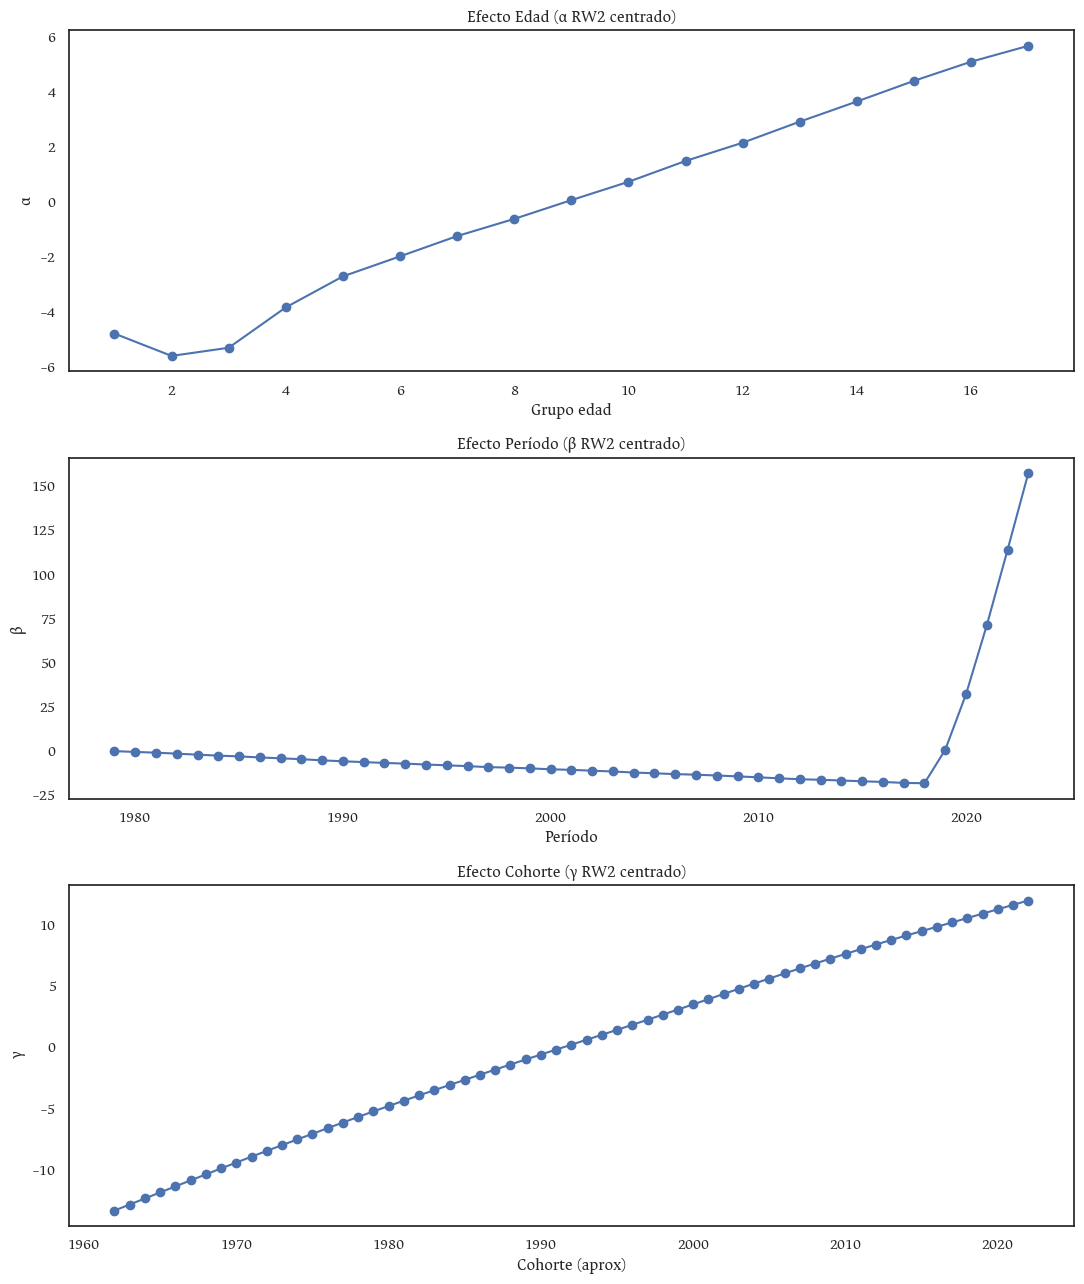

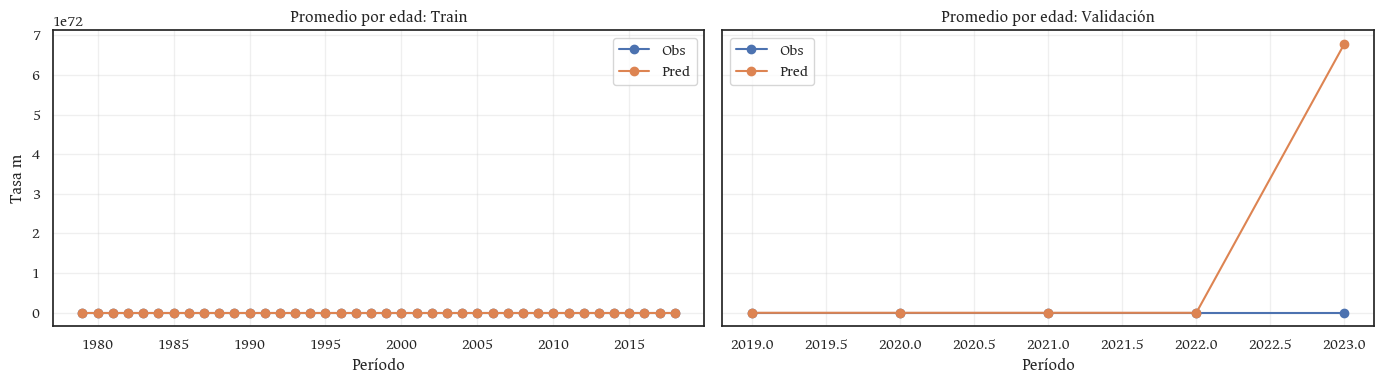

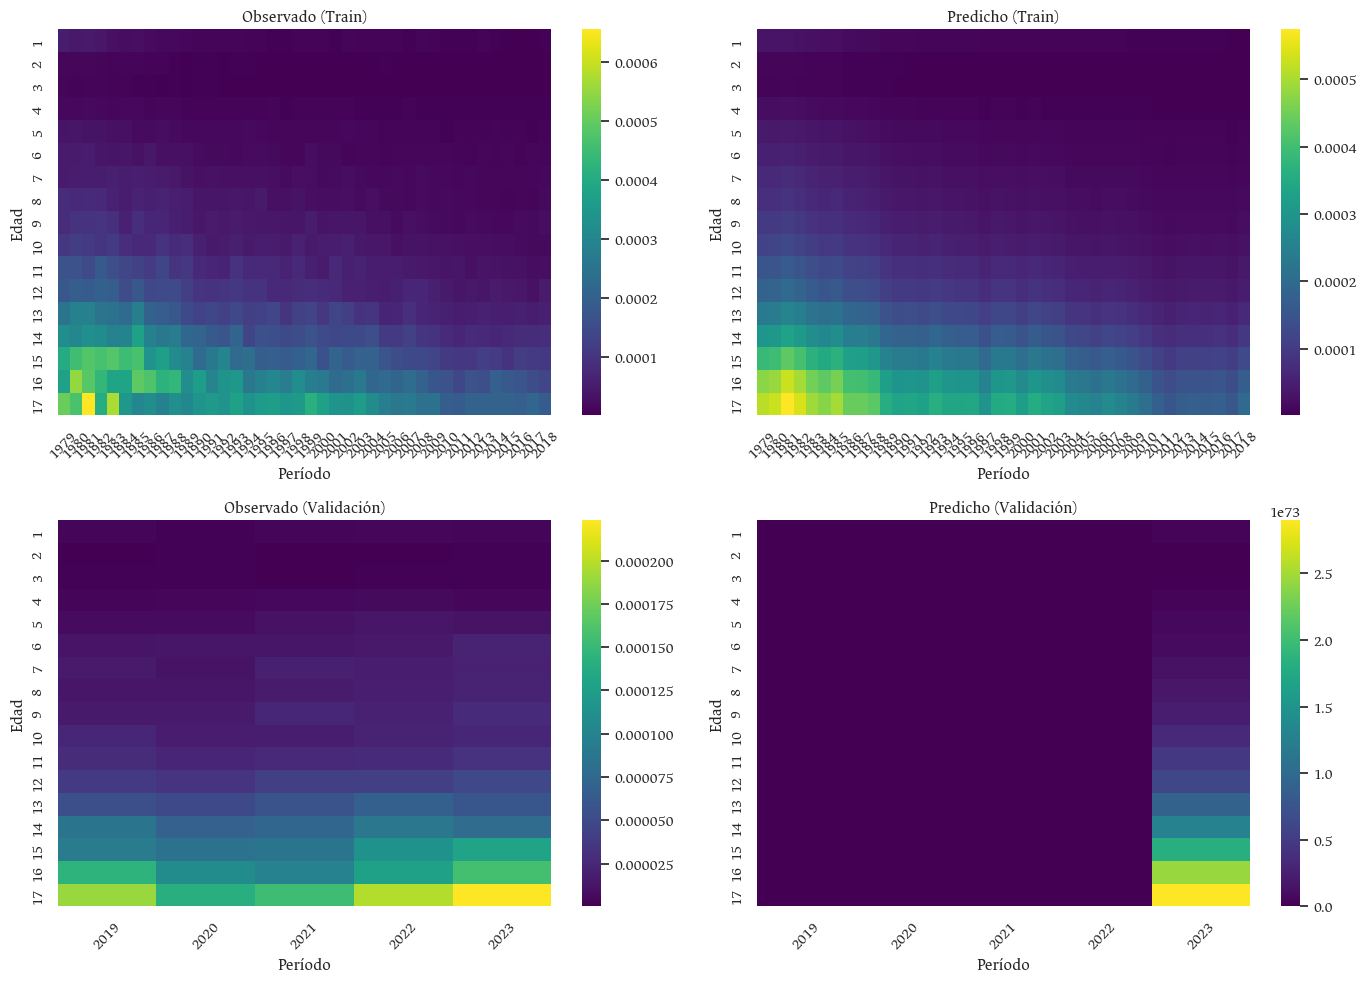

Métricas:
- Train  | RMSE: 2.2205e-05 | MAPE: 15.59%
- Val    | RMSE: 4.9737e+72 | MAPE: 2094453517732099657547777777693323764215776525612723120834025181332469956214784.00%


In [13]:
# Visualizaciones de parámetros y desempeño (RW2)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Medias posteriores centradas
alpha_mean = alpha_post_c.mean(axis=(0,1))
beta_mean = beta_post_c.mean(axis=(0,1))
gamma_mean = gamma_post_c.mean(axis=(0,1))

fig, axs = plt.subplots(3,1, figsize=(11,13), sharex=False)
axs[0].plot(ages, alpha_mean, marker='o')
axs[0].set_title('Efecto Edad (α RW2 centrado)')
axs[0].set_xlabel('Grupo edad')
axs[0].set_ylabel('α')

axs[1].plot(all_periods, beta_mean[:len(all_periods)], marker='o')
axs[1].set_title('Efecto Período (β RW2 centrado)')
axs[1].set_xlabel('Período')
axs[1].set_ylabel('β')

axs[2].plot(all_cohorts, gamma_mean, marker='o')
axs[2].set_title('Efecto Cohorte (γ RW2 centrado)')
axs[2].set_xlabel('Cohorte (aprox)')
axs[2].set_ylabel('γ')
plt.tight_layout()
plt.show()

# Comparación agregada por período (train y validación)
df_period_train = df_train_eval.groupby('period')[['obs','pred']].mean().reset_index()
df_period_val = df_val_eval.groupby('period')[['obs','pred']].mean().reset_index()

fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs'], label='Obs', marker='o')
ax[0].plot(df_period_train['period'], df_period_train['pred'], label='Pred', marker='o')
ax[0].set_title('Promedio por edad: Train')
ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa m'); ax[0].grid(alpha=0.3); ax[0].legend()

ax[1].plot(df_period_val['period'], df_period_val['obs'], label='Obs', marker='o')
ax[1].plot(df_period_val['period'], df_period_val['pred'], label='Pred', marker='o')
ax[1].set_title('Promedio por edad: Validación')
ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend()
plt.tight_layout(); plt.show()

# Heatmaps: observado vs predicho (train y validación)
mat_train_pred = m_train_pred_mean.reshape(n_age, len(train_periods))
mat_val_pred = m_val_pred_mean.reshape(n_age, len(val_periods))

fig, ax = plt.subplots(2,2, figsize=(14,10))
sns.heatmap(train_mat.values, ax=ax[0,0], cmap='viridis', xticklabels=train_periods, yticklabels=ages)
ax[0,0].set_title('Observado (Train)')
ax[0,0].set_xlabel('Período'); ax[0,0].set_ylabel('Edad')
for label in ax[0,0].get_xticklabels():
    label.set_rotation(45)

sns.heatmap(mat_train_pred, ax=ax[0,1], cmap='viridis', xticklabels=train_periods, yticklabels=ages)
ax[0,1].set_title('Predicho (Train)')
ax[0,1].set_xlabel('Período'); ax[0,1].set_ylabel('Edad')
for label in ax[0,1].get_xticklabels():
    label.set_rotation(45)

sns.heatmap(val_mat.values, ax=ax[1,0], cmap='viridis', xticklabels=val_periods, yticklabels=ages)
ax[1,0].set_title('Observado (Validación)')
ax[1,0].set_xlabel('Período'); ax[1,0].set_ylabel('Edad')
for label in ax[1,0].get_xticklabels():
    label.set_rotation(45)

sns.heatmap(mat_val_pred, ax=ax[1,1], cmap='viridis', xticklabels=val_periods, yticklabels=ages)
ax[1,1].set_title('Predicho (Validación)')
ax[1,1].set_xlabel('Período'); ax[1,1].set_ylabel('Edad')
for label in ax[1,1].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout(); plt.show()

print("Métricas:")
print(f"- Train  | RMSE: {RMSE_train:.4e} | MAPE: {MAPE_train:.2f}%")
print(f"- Val    | RMSE: {RMSE_val:.4e} | MAPE: {MAPE_val:.2f}%")